<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/rot_2_dim_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [442]:
#!pip install playground-data

In [443]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler

import plygdata as pg

In [444]:
class DigitsDataset(Dataset):
    def __init__(self, transform=None):
        dataset = torch.tensor(pg.dataset.DataGenerator.classify_xor(1000,noise=0.1))
        self.target = dataset[:,2]
        self.data = dataset[:,:2]

        self.transform = transform
        #self.scaler = StandardScaler()
        #self.data = self.scaler.fit_transform(self.data.astype(float))  # Standardize the data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx], self.target[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

# Example usage:
digits_dataset = DigitsDataset()

# Get data and target
data = digits_dataset.data
target = digits_dataset.target

print("Data shape:", data.shape)
print("Target shape:", target.shape)

Data shape: torch.Size([1000, 2])
Target shape: torch.Size([1000])


In [445]:
"""class DigitsDataset(Dataset):
    def __init__(self, transform=None):
        self.data, self.target = load_digits(return_X_y=True)
        self.transform = transform
        self.scaler = StandardScaler()
        self.data = self.scaler.fit_transform(self.data.astype(float))  # Standardize the data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.from_numpy(self.data[idx]).to(torch.float32), self.target[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

# Example usage:
digits_dataset = DigitsDataset()

# Get data and target
data = digits_dataset.data
target = digits_dataset.target

print("Data shape:", data.shape)
print("Target shape:", target.shape)"""

'class DigitsDataset(Dataset):\n    def __init__(self, transform=None):\n        self.data, self.target = load_digits(return_X_y=True)\n        self.transform = transform\n        self.scaler = StandardScaler()\n        self.data = self.scaler.fit_transform(self.data.astype(float))  # Standardize the data\n        \n    def __len__(self):\n        return len(self.data)\n    \n    def __getitem__(self, idx):\n        sample = torch.from_numpy(self.data[idx]).to(torch.float32), self.target[idx]\n        \n        if self.transform:\n            sample = self.transform(sample)\n            \n        return sample\n\n# Example usage:\ndigits_dataset = DigitsDataset()\n\n# Get data and target\ndata = digits_dataset.data\ntarget = digits_dataset.target\n\nprint("Data shape:", data.shape)\nprint("Target shape:", target.shape)'

In [446]:
# Define batch size
batch_size = 64

# Create DataLoader
data_loader = DataLoader(digits_dataset, batch_size=batch_size, shuffle=True)

# Example usage:
for batch_idx, (data, target) in enumerate(data_loader):
    print("Batch:", batch_idx)
    print("Data shape:", data.shape)
    print("Target shape:", target.shape)

Batch: 0
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 1
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 2
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 3
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 4
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 5
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 6
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 7
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 8
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 9
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 10
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 11
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 12
Data shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Batch: 13
Data shape: torch.Size([64, 2])
Target shape: torch

In [447]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()

        # Create a uniform distribution
        self.uni_dist = torch.distributions.uniform.Uniform(0, 1)

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)

        angle = encoded * self.uni_dist.sample((1,))

        decoded = self.decoder(angle)
        return angle, decoded

# Example usage:
input_dim = 2  # Assuming input images are 28x28 pixels
latent_dim = 1  # Dimensionality of the latent space

# Create an instance of the autoencoder model
model = Autoencoder(input_dim, latent_dim)

# Define loss function (e.g., Mean Squared Error) and optimizer (e.g., Adam)
#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [448]:
def criterion(x, angle, x_hat):
  loss = 0

  for theta in range(x.shape[0]):
    loss += (torch.matmul(torch.tensor([[torch.cos(angle[theta]), -torch.sin(angle[theta])],
                                [torch.sin(angle[theta]), torch.cos(angle[theta])]]), x[theta].T).T - x_hat[theta])**2
  return loss.mean()

In [449]:
# Set random seed for reproducibility
torch.manual_seed(42)

num_epochs = 500

In [450]:
for epoch in range(num_epochs):
    train_loss = 0.0

    for batch_data, _ in data_loader:

        optimizer.zero_grad()
        angle, reconstructed = model(batch_data)

        loss = criterion(batch_data, angle, reconstructed)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(data_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

Epoch 1/500, Train Loss: 8.7603
Epoch 2/500, Train Loss: 9.3225
Epoch 3/500, Train Loss: 7.2611
Epoch 4/500, Train Loss: 8.2292
Epoch 5/500, Train Loss: 8.3126
Epoch 6/500, Train Loss: 8.7120
Epoch 7/500, Train Loss: 9.2576
Epoch 8/500, Train Loss: 8.8502
Epoch 9/500, Train Loss: 9.2453
Epoch 10/500, Train Loss: 9.0067
Epoch 11/500, Train Loss: 9.0455
Epoch 12/500, Train Loss: 9.0334
Epoch 13/500, Train Loss: 8.8391
Epoch 14/500, Train Loss: 8.9683
Epoch 15/500, Train Loss: 8.6463
Epoch 16/500, Train Loss: 8.8769
Epoch 17/500, Train Loss: 8.4737
Epoch 18/500, Train Loss: 8.6052
Epoch 19/500, Train Loss: 8.2959
Epoch 20/500, Train Loss: 7.9934
Epoch 21/500, Train Loss: 8.1155
Epoch 22/500, Train Loss: 7.9829
Epoch 23/500, Train Loss: 8.0257
Epoch 24/500, Train Loss: 7.6360
Epoch 25/500, Train Loss: 8.0820
Epoch 26/500, Train Loss: 8.1778
Epoch 27/500, Train Loss: 7.8782
Epoch 28/500, Train Loss: 7.4625
Epoch 29/500, Train Loss: 7.9535
Epoch 30/500, Train Loss: 7.3805
Epoch 31/500, Train

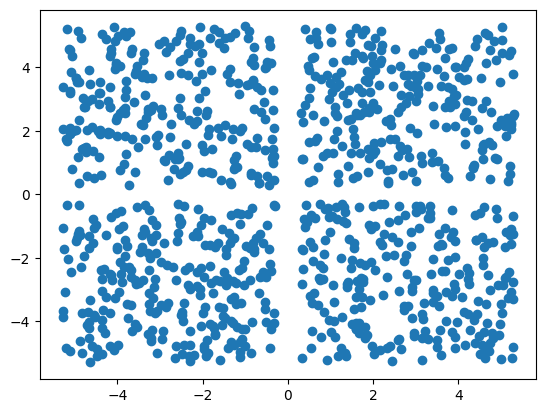

In [451]:
plt.scatter(digits_dataset.data[:,0], digits_dataset.data[:,1])

In [452]:
uniform_dist = torch.distributions.uniform.Uniform(0,1)
sample = uniform_dist.sample((1000,))* torch.math.pi/2

In [453]:
sonuc = model.decoder(sample.reshape(-1,1))

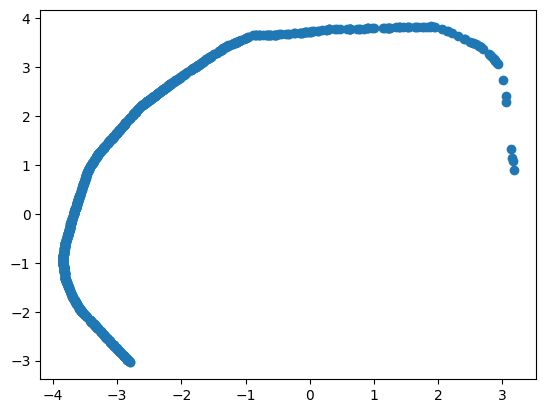

In [454]:
plt.scatter(sonuc[:,0].detach().numpy(), sonuc[:,1].detach().numpy())